In [1]:
import librosa
import numpy as np
import soundfile as sf
import scipy.signal as ss

## STFT APPLICATION ON THE ORIGINAL AUDIO EXTRACTED FROM YOUTUBE

In [56]:
import numpy as np
import librosa
import librosa.display
import scipy.signal as ss
import soundfile as sf
import matplotlib.pyplot as plt

# =========================
# 1. Load original audio
# =========================
audio_path = "../ReferenceAudio/BlueWhaleCrying.wav"
y, sr = librosa.load(audio_path, sr=None)

# =========================
# 2. Denoise using YOUR METHOD
# =========================

# STFT (complex spectrum)
S_complex = librosa.stft(y)
# Magnitude and phase
s_full, phase = librosa.magphase(S_complex)  # s_full = |S|, phase = complex phase info

# Noise estimate:
# mean of first 0.1 * sr columns (⚠ note: this is actually mixing samples and frames,
# but we'll keep your math exactly as given)
noise_power = np.mean(s_full[:, :int(sr * 0.1)], axis=1)  # shape: [freq_bins]

# Binary mask: keep bins stronger than estimated noise
mask = s_full > noise_power[:, None]
mask = mask.astype(float)

# Median filter in time to smooth mask
mask = ss.medfilt(mask, kernel_size=(1, 5))

# Apply mask to magnitude
s_clean = mask * s_full

# Rebuild complex STFT using cleaned magnitude and original phase
S_clean = s_clean * phase

# Inverse STFT back to time domain
y_clean = librosa.istft(S_clean)

# Save the denoised audio
sf.write("denoised_whale123.wav", y_clean, sr)
print("Exported denoised_whale.wav")

# =========================
# 3. Helper features for plotting
# =========================
import numpy as np
import librosa

def extract_features(y, sr):
    """
    Extract main acoustic features from a denoised whale call:
    - duration
    - RMS energy
    - spectral centroid
    - f0 (mean fundamental frequency)
    """

    duration_sec = len(y) / sr
    rms = librosa.feature.rms(y=y)[0]
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]

    # --- Improved pitch detection ---
    try:
        # Broader f0 range suitable for whales
        f0, voiced_flag, voiced_prob = librosa.pyin(
            y,
            fmin=5.0,          # allow deep infrasonic tones
            fmax=1000.0,       # include higher harmonics
            frame_length=8192, # larger window for low frequencies
            hop_length=512
        )

        # If pyin fails completely, f0 will be all NaNs
        if np.all(np.isnan(f0)):
            raise ValueError("No pitch detected")

        # Clean and average
        f0_nonan = f0[~np.isnan(f0)]
        f0_mean_hz = float(np.mean(f0_nonan)) if len(f0_nonan) > 0 else 0.0

    except Exception:
        # --- Fallback pitch estimate using dominant frequency ---
        S = np.abs(librosa.stft(y, n_fft=8192))
        freqs = librosa.fft_frequencies(sr=sr, n_fft=8192)
        mean_spectrum = np.mean(S, axis=1)
        peak_idx = np.argmax(mean_spectrum)
        f0_mean_hz = float(freqs[peak_idx])

    # Return feature summary
    return {
        "duration_sec": duration_sec,
        "rms_mean": float(np.mean(rms)),
        "centroid_mean_hz": float(np.mean(centroid)),
        "f0_mean_hz": f0_mean_hz,
    }


features_raw = extract_features(y, sr)
features_clean = extract_features(y_clean, sr)


Exported denoised_whale.wav


C:\Users\edupa\AppData\Local\Temp\ipykernel_17324\2977628003.py:70: UserWarning: With fmin=5.000, sr=22050 and frame_length=8192, less than two periods of fmin fit into the frame, which can cause inaccurate pitch detection. Consider increasing to fmin=5.383 or frame_length=8821.
  f0, voiced_flag, voiced_prob = librosa.pyin(


## DATASET EXTRACTION from hugging face (clone repo)

In [ ]:
import os
import io
import numpy as np
import soundfile as sf
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd

# 1. Load the Arrow table directly (no to_pandas yet)
parquet_path = r"..\humpbacks-orcasound-em-hW-data\data\train-00000-of-00006.parquet"
table = pq.read_table(parquet_path)

# 2. Let's inspect schema so we know column names and types
print("Schema:")
print(table.schema)

# 3. Convert each column we care about to Python lists (except audio)
# We'll handle 'audio' manually
cols = table.column_names
print("Columns:", cols)


Schema:
Selection: int64
BeginTime: double
EndTime: double
LowFreq: double
HighFreq: double
CallType: string
Filename: string
VocalizationDuration: double
Audio: struct<bytes: binary, path: string>
  child 0, bytes: binary
  child 1, path: string
-- schema metadata --
huggingface: '{"info": {"features": {"Selection": {"dtype": "int64", "_ty' + 442
Columns: ['Selection', 'BeginTime', 'EndTime', 'LowFreq', 'HighFreq', 'CallType', 'Filename', 'VocalizationDuration', 'Audio']


In [55]:
import os
import io
import soundfile as sf
import pandas as pd

os.makedirs("public_raw_300", exist_ok=True)

max_clips = 300
export_meta = []

# Get column indices to avoid string lookup in loop
col_idx = {name: i for i, name in enumerate(table.column_names)}

# Helper to get a value from a row safely
def get_value(col_name, row_idx):
    if col_name not in col_idx:
        return None
    col = table.column(col_idx[col_name])
    # Arrow -> Python scalar
    return col[row_idx].as_py()

# We'll loop over row indexes directly
num_rows = table.num_rows
count = 0

for row_idx in range(num_rows):
    if count >= max_clips:
        break

    # 1. Get the audio struct cell (Arrow struct: {'bytes': ..., 'path': ...})
    # Try "audio" first, then "Audio"
    audio_cell = None
    if "audio" in col_idx:
        audio_cell = table.column(col_idx["audio"])[row_idx].as_py()
    elif "Audio" in col_idx:
        audio_cell = table.column(col_idx["Audio"])[row_idx].as_py()
    else:
        print("No audio column found, stopping.")
        break

    # audio_cell should now be a dict like {'bytes': b'RIFF...', 'path': '...'}
    if audio_cell is None or "bytes" not in audio_cell:
        # No usable audio => skip
        continue

    audio_bytes = audio_cell["bytes"]

    # 2. Decode bytes into waveform using soundfile
    try:
        with sf.SoundFile(io.BytesIO(audio_bytes)) as f:
            y = f.read(dtype="float32")
            sr = f.samplerate
    except RuntimeError as e:
        # sometimes the bytes might not be WAV; skip if decode fails
        print(f"Skipping row {row_idx}: could not decode audio ({e})")
        continue

    # 3. Save to disk
    out_name = f"humpback_{count:04d}.wav"
    out_path = os.path.join("public_raw_300", out_name)
    sf.write(out_path, y, sr)

    # 4. Collect metadata from other columns
    export_meta.append({
        "filename": out_path,
        "sr": sr,
        "Selection": get_value("Selection", row_idx),
        "BeginTime": get_value("BeginTime", row_idx),
        "EndTime": get_value("EndTime", row_idx),
        "LowFreq": get_value("LowFreq", row_idx),
        "HighFreq": get_value("HighFreq", row_idx),
        "CallType": get_value("CallType", row_idx),
        "VocalizationDuration": get_value("VocalizationDuration", row_idx),
        "OriginalFile": get_value("Filename", row_idx),
        "SourceParquet": os.path.basename(parquet_path),
    })

    count += 1

print(f"✅ Exported {count} clips from {parquet_path}")

# 5. Save metadata for these clips
meta_df = pd.DataFrame(export_meta)
meta_df.to_csv("public_raw_300/metadata_raw.csv", index=False)



✅ Exported 253 clips from ..\humpbacks-orcasound-em-hW-data\data\train-00000-of-00006.parquet


In [ ]:
meta_df.head(1)

,filename,sr,Selection,BeginTime,EndTime,LowFreq,HighFreq,CallType,VocalizationDuration,OriginalFile,SourceParquet
0,public_raw_300\humpback_0000.wav,44100,1,1.812867,3.187133,263.518,2845.995,Descending_moan,1.374266,211026-133018-OS-humpback-47min-clip_1.wav,train-00000-of-00006.parquet


Row info:
 file:        public_raw_300\humpback_0000.wav
 expected sr: 44100
 call_type:   Descending_moan
 start (s):   1.81286695
 end   (s):   3.18713305
 clip dur(s): 1.3742661
 from file:   211026-133018-OS-humpback-47min-clip_1.wav
Saved raw segment to raw_first_call.wav
Saved denoised segment to denoised_first_call.wav

=== Stats BEFORE denoise ===
duration_sec: 1.3742630385487529
rms_mean: 0.004101282451301813
centroid_mean_hz: 5317.533156468263

=== Stats AFTER denoise ===
duration_sec: 1.3699773242630386
rms_mean: 0.1659868210554123
centroid_mean_hz: 5464.562856913272

=== Denoise delta (after - before) ===
Centroid change (Hz): 147.03 Hz


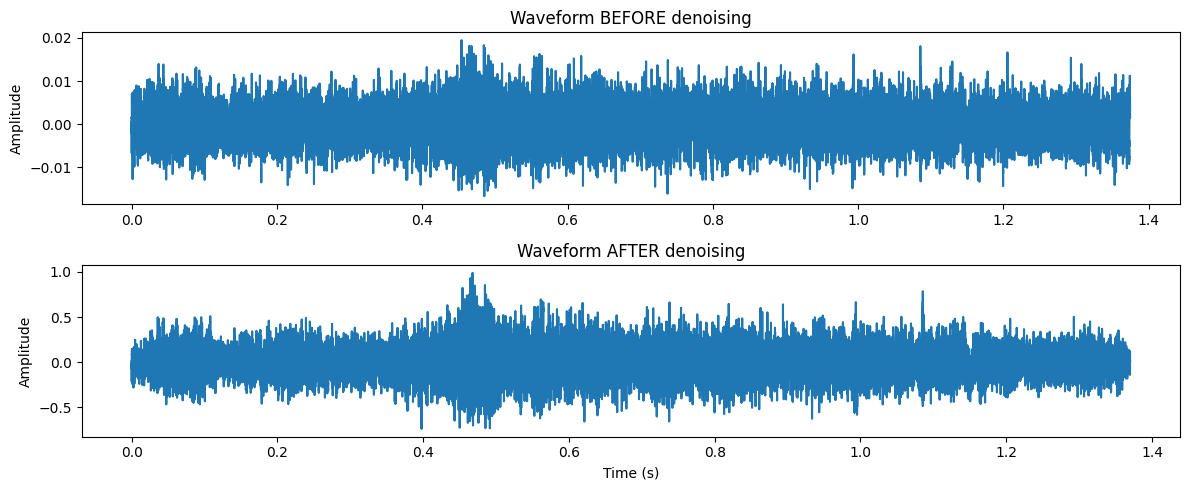

In [ ]:
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import scipy.signal as ss
import matplotlib.pyplot as plt

########################################
# 1. CONFIG
########################################

# path to your metadata table (CSV or parquet)
# if it's CSV:

# if it's parquet instead, replace the read step later

# root folder where the wav files live, if needed
AUDIO_ROOT = "."  # change if paths in the dataframe are relative

output_clean_wav = "denoised_first_call.wav"
output_raw_wav   = "raw_first_call.wav"

########################################
# 2. DENOISE FUNCTION (YOUR ORIGINAL METHOD)
########################################

def denoise_original(y, sr):
    """
    This is exactly your denoising method:
    STFT -> magnitude/phase -> noise estimate from first 0.1*sr frames ->
    binary mask -> median filter -> apply -> iSTFT
    """
    # STFT (complex)
    S_complex = librosa.stft(y)

    # magnitude and phase
    s_full, phase = librosa.magphase(S_complex)

    # noise estimate from the first int(sr*0.1) frames
    # NOTE: this mixes samples vs frames, but we are preserving your logic.
    noise_power = np.mean(s_full[:, :int(sr * 0.1)], axis=1)

    # build mask
    mask = s_full > noise_power[:, None]
    mask = mask.astype(float)

    # median filter mask over time to smooth
    mask = ss.medfilt(mask, kernel_size=(1, 5))

    # apply mask
    s_clean = mask * s_full

    # reconstruct complex STFT
    S_clean = s_clean * phase

    # inverse STFT
    y_clean = librosa.istft(S_clean)

    # simple peak normalize to avoid clipping in output
    peak = np.max(np.abs(y_clean))
    if peak > 0:
        y_clean = 0.99 * y_clean / peak

    return y_clean


########################################
# 3. FEATURE / STATS EXTRACTION
########################################

def compute_stats(y, sr):
    """
    Returns simple numeric summaries for the signal:
    - duration (s)
    - mean RMS energy
    - mean spectral centroid
    """

    duration_sec = len(y) / sr

    # RMS framewise
    rms = librosa.feature.rms(y=y)[0]  # shape [frames]
    rms_mean = float(np.mean(rms))

    # spectral centroid (where energy is in freq)
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    centroid_mean_hz = float(np.mean(centroid))

    return {
        "duration_sec": duration_sec,
        "rms_mean": rms_mean,
        "centroid_mean_hz": centroid_mean_hz,
    }


########################################
# 4. VISUALIZATION (optional but nice)
########################################

def plot_before_after(y_raw, y_clean, sr):
    t_raw = np.linspace(0, len(y_raw)/sr, len(y_raw))
    t_clean = np.linspace(0, len(y_clean)/sr, len(y_clean))

    fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=False)

    axs[0].plot(t_raw, y_raw)
    axs[0].set_title("Waveform BEFORE denoising")
    axs[0].set_ylabel("Amplitude")

    axs[1].plot(t_clean, y_clean)
    axs[1].set_title("Waveform AFTER denoising")
    axs[1].set_ylabel("Amplitude")
    axs[1].set_xlabel("Time (s)")

    plt.tight_layout()
    plt.show()


########################################
# 5. MAIN PIPELINE
########################################

# --- Load metadata table
# CSV version:
df = meta_df

# (If your source is parquet instead of CSV, do this instead:
# df = pd.read_parquet("train-00000-of-00006.parquet")
# )

# --- Take the first row
row = df.iloc[0]

# pull fields
audio_file_path = row["filename"]              # e.g. "public_raw_300\\humpback_0000.wav"
sr_expected     = row["sr"]                    # e.g. 44100
t_start         = row["BeginTime"]             # e.g. 1.812867 seconds
t_end           = row["EndTime"]               # e.g. 3.187133 seconds
call_type       = row["CallType"]              # e.g. "Descending_moan"
orig_file_name  = row["OriginalFile"]          # for reference
clip_duration   = row["VocalizationDuration"]  # provided in table

print("====================================")
print("Row info:")
print(f" file:        {audio_file_path}")
print(f" expected sr: {sr_expected}")
print(f" call_type:   {call_type}")
print(f" start (s):   {t_start}")
print(f" end   (s):   {t_end}")
print(f" clip dur(s): {clip_duration}")
print(f" from file:   {orig_file_name}")
print("====================================")

# --- Load the audio file
# join AUDIO_ROOT with filename if needed
full_wav_path = f"{AUDIO_ROOT}/{audio_file_path}"

y_full, sr_file = librosa.load(full_wav_path, sr=None)

if sr_file != sr_expected:
    print(f"WARNING: file sr={sr_file} but dataset sr={sr_expected}. We'll use {sr_file}.")

# --- Extract JUST the labeled whale call segment
start_sample = int(t_start * sr_file)
end_sample   = int(t_end   * sr_file)

y_call = y_full[start_sample:end_sample]

# Save raw call segment so you can listen directly
sf.write(output_raw_wav, y_call, sr_file)
print(f"Saved raw segment to {output_raw_wav}")

# --- Apply YOUR denoise to that segment
y_call_denoised = denoise_original(y_call, sr_file)

# Save denoised call segment so you can A/B listen
sf.write(output_clean_wav, y_call_denoised, sr_file)
print(f"Saved denoised segment to {output_clean_wav}")

# --- Compute stats before / after
stats_before = compute_stats(y_call, sr_file)
stats_after  = compute_stats(y_call_denoised, sr_file)

print("\n=== Stats BEFORE denoise ===")
for k, v in stats_before.items():
    print(f"{k}: {v}")

print("\n=== Stats AFTER denoise ===")
for k, v in stats_after.items():
    print(f"{k}: {v}")

# You can also compute simple "improvement" metrics:
rms_reduction = stats_before["rms_mean"] - stats_after["rms_mean"]
centroid_shift = stats_after["centroid_mean_hz"] - stats_before["centroid_mean_hz"]

print("\n=== Denoise delta (after - before) ===")
print(f"Centroid change (Hz): {centroid_shift:.2f} Hz")

# --- Plot before/after waveforms for sanity
plot_before_after(y_call, y_call_denoised, sr_file)


## Apply STFT on the original dataset (extracted dataset from the repository)

In [26]:
import os
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import scipy.signal as ss

# =========================================================
# CONFIG
# =========================================================

# path to your metadata file
# if CSV:
METADATA_PATH = "public_raw_300/metadata_raw.csv"
# if parquet, replace read_csv with pd.read_parquet below

# base folder for original .wav files
AUDIO_ROOT = "."  # change this if df['filename'] is relative to some other directory

# output folder for denoised wavs
OUTPUT_AUDIO_DIR = "denoised_wavs"
os.makedirs(OUTPUT_AUDIO_DIR, exist_ok=True)

# output CSV with features
OUTPUT_FEATURES_CSV = "features_after_denoise.csv"


# =========================================================
# YOUR ORIGINAL DENOISE FUNCTION
# (unchanged logic)
# =========================================================
def denoise_original(y, sr):
    """
    Your original denoising approach:
    1. STFT
    2. magnitude/phase split
    3. noise estimate from first int(sr*0.1) "frames"
    4. binary mask
    5. median filter mask
    6. inverse STFT
    """
    S_complex = librosa.stft(y)
    s_full, phase = librosa.magphase(S_complex)

    noise_power = np.mean(s_full[:, :int(sr * 0.1)], axis=1)

    mask = s_full > noise_power[:, None]
    mask = mask.astype(float)

    mask = ss.medfilt(mask, kernel_size=(1, 5))

    s_clean = mask * s_full
    S_clean = s_clean * phase

    y_clean = librosa.istft(S_clean)

   

    return y_clean


# =========================================================
# FEATURE EXTRACTION
# =========================================================
def extract_features(y, sr, fmin=20.0):
    """
    Compute summary stats from signal y:
    - duration_sec
    - mean RMS energy
    - mean spectral centroid
    - mean pitch (f0) if pyin detects it, else 0
    """
    duration_sec = len(y) / sr

    # RMS over frames
    rms = librosa.feature.rms(y=y)[0]  # shape (frames,)
    rms_mean = float(np.mean(rms))

    # spectral centroid
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)[0]
    centroid_mean_hz = float(np.mean(centroid))

    # pitch / f0 using pyin
    # pyin can fail for very noisy / low-frequency calls; we handle that
    try:
        f0, voiced_flag, voiced_prob = librosa.pyin(
            y,
            fmin=fmin,
            fmax=sr / 2.0,
        )
        # replace NaNs with 0 for averaging
        f0_nonan = np.where(np.isnan(f0), 0.0, f0)
        f0_mean_hz = float(np.mean(f0_nonan))
    except Exception:
        f0_mean_hz = 0.0

    stats = {
        "duration_sec": duration_sec,
        "rms_mean": rms_mean,
        "centroid_mean_hz": centroid_mean_hz,
        "f0_mean_hz": f0_mean_hz,
    }
    return stats


# =========================================================
# MAIN LOOP
# =========================================================
def process_dataset():
    # --- Load metadata
    # df = pd.read_parquet(METADATA_PATH)   # if parquet
    df = pd.read_csv(METADATA_PATH)

    # We'll collect per-row results in a list of dicts
    feature_rows = []

    # We'll cache loaded audio so we don't reload same file multiple times
    # (in case your dataset has multiple rows pointing to the same WAV
    #  with different BeginTime / EndTime)
    audio_cache = {}

    for idx, row in df.iterrows():
        filename = row["filename"]          # ex: public_raw_300\humpback_0000.wav
        sr_expected = row["sr"]             # ex: 44100
        t_start = row["BeginTime"]          # start time (sec)
        t_end = row["EndTime"]              # end time (sec)
        call_type = row["CallType"]         # label / class
        clip_dur = row["VocalizationDuration"]

        # Resolve path for audio on disk
        full_path = os.path.join(AUDIO_ROOT, filename)

        # Load audio (from cache if possible)
        if full_path not in audio_cache:
            y_full, sr_file = librosa.load(full_path, sr=None)
            audio_cache[full_path] = (y_full, sr_file)
        else:
            y_full, sr_file = audio_cache[full_path]

        # Warn if mismatch in sample rate metadata vs actual
        if sr_file != sr_expected:
            # Not stopping, just letting you know
            print(
                f"[row {idx}] WARNING: file sr={sr_file} but 'sr' column={sr_expected}. Using {sr_file}."
            )

        # Cut the segment for THIS annotation
        start_sample = int(t_start * sr_file)
        end_sample = int(t_end * sr_file)

        # clamp just in case metadata is slightly out of bounds
        start_sample = max(0, start_sample)
        end_sample = min(len(y_full), max(start_sample, end_sample))

        y_segment = y_full[start_sample:end_sample]

        # Denoise that segment
        y_denoised = denoise_original(y_segment, sr_file)

        # Save denoised clip: we’ll name it using the row index to avoid collisions
        # ex: denoised_wavs/000000_humpback_0000_denoised.wav
        original_base = os.path.basename(filename).replace("\\", "_").replace("/", "_")
        out_wav_name = f"{idx:06d}_{original_base}_denoised.wav"
        out_wav_path = os.path.join(OUTPUT_AUDIO_DIR, out_wav_name)

        sf.write(out_wav_path, y_denoised, sr_file)

        # Extract features from the denoised segment
        stats = extract_features(y_denoised, sr_file)

        # Add metadata so we can analyze later
        row_result = {
            "row_index": idx,
            "source_wav": filename,
            "denoised_wav": out_wav_path,
            "sr_used": sr_file,
            "BeginTime": t_start,
            "EndTime": t_end,
            "CallType": call_type,
            "VocalizationDuration": clip_dur,
        }
        row_result.update(stats)  # merge duration_sec, rms_mean, centroid_mean_hz, f0_mean_hz

        feature_rows.append(row_result)

        print(f"[row {idx}] processed {filename} -> {out_wav_path}")

    # Build dataframe with all features
    features_df = pd.DataFrame(feature_rows)

    # Save features to CSV
    features_df.to_csv(OUTPUT_FEATURES_CSV, index=False)
    print(f"\nAll done. Saved features to {OUTPUT_FEATURES_CSV}")
    print(f"Denoised clips are in {OUTPUT_AUDIO_DIR}/")

    return features_df


if __name__ == "__main__":
    features_df = process_dataset()


[row 0] processed public_raw_300\humpback_0000.wav -> denoised_wavs\000000_humpback_0000.wav_denoised.wav
[row 1] processed public_raw_300\humpback_0001.wav -> denoised_wavs\000001_humpback_0001.wav_denoised.wav
[row 2] processed public_raw_300\humpback_0002.wav -> denoised_wavs\000002_humpback_0002.wav_denoised.wav
[row 3] processed public_raw_300\humpback_0003.wav -> denoised_wavs\000003_humpback_0003.wav_denoised.wav
[row 4] processed public_raw_300\humpback_0004.wav -> denoised_wavs\000004_humpback_0004.wav_denoised.wav
[row 5] processed public_raw_300\humpback_0005.wav -> denoised_wavs\000005_humpback_0005.wav_denoised.wav
[row 6] processed public_raw_300\humpback_0006.wav -> denoised_wavs\000006_humpback_0006.wav_denoised.wav
[row 7] processed public_raw_300\humpback_0007.wav -> denoised_wavs\000007_humpback_0007.wav_denoised.wav
[row 8] processed public_raw_300\humpback_0008.wav -> denoised_wavs\000008_humpback_0008.wav_denoised.wav
[row 9] processed public_raw_300\humpback_0009

## Wave length of the signal based on the callType (class : types of noise)
We distinguish multiple classes as seen in the dataset and we want to study the bandwidth related to each class by getting th LowFreq Vs High Freq


=== Frequency Band Summary by CallType (Hz) ===
                  n  low_min_Hz  low_mean_Hz  low_max_Hz  high_min_Hz  \
CallType                                                                
Whup             19      37.267   135.338053     223.602      931.677   
Harmonica         2     633.540   913.043500    1192.547     1378.882   
Buzz             14     298.137   495.119786     745.342     1304.348   
Grunt            27       0.000   142.166741     260.870     1043.478   
Creak             5     298.137   380.124400     484.472     1639.752   
Growl            11      37.267   162.279273     372.671     1527.950   
Upsweep           4     298.137   326.087250     372.671     1788.820   
Descending_moan  17     149.068   250.752176     372.671      782.609   
Chirp            15     708.075  1730.075467    3689.441     1602.484   
Vibrate           4     186.335   326.087000     521.739     1639.752   
Trumpet          22      74.534   186.335273     298.137     1900.621   
Sh

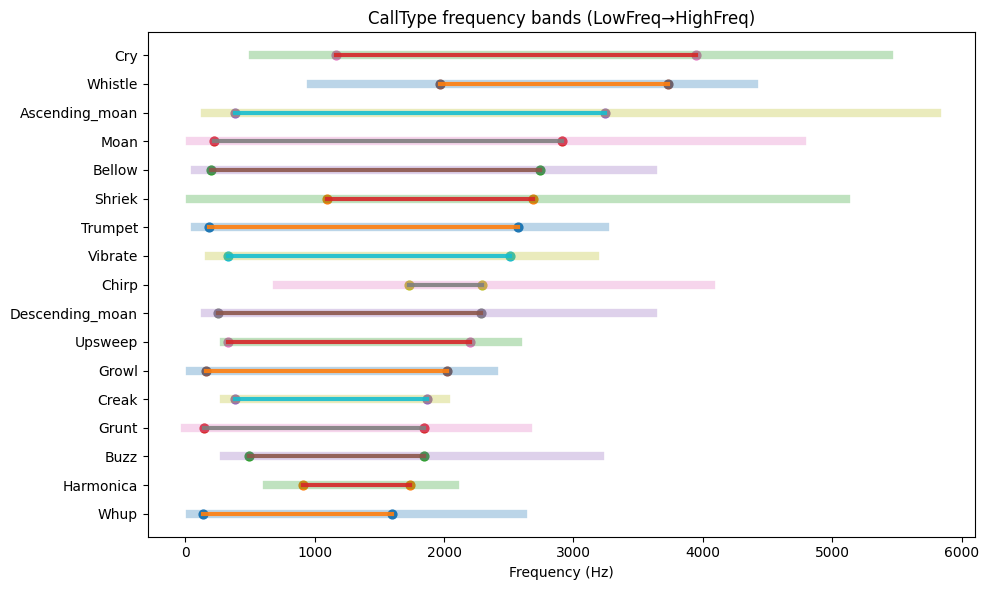

<Figure size 1000x500 with 0 Axes>

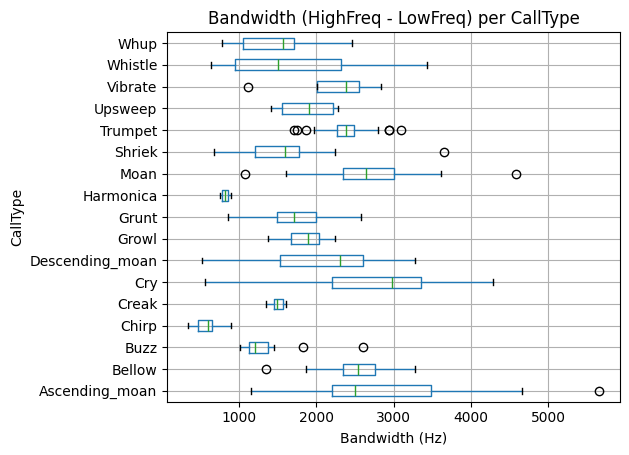

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to your original metadata table with columns:
# filename, sr, Selection, BeginTime, EndTime, LowFreq, HighFreq, CallType, ...
METADATA_PATH = "public_raw_300/metadata_raw.csv."

df = pd.read_csv(METADATA_PATH)

# Clean up / sanity: ensure numeric
df["LowFreq"] = pd.to_numeric(df["LowFreq"], errors="coerce")
df["HighFreq"] = pd.to_numeric(df["HighFreq"], errors="coerce")

# Compute bandwidth per row
df["Bandwidth_Hz"] = df["HighFreq"] - df["LowFreq"]

# Drop rows with missing freq bounds
df_valid = df.dropna(subset=["LowFreq", "HighFreq", "Bandwidth_Hz"]).copy()

# -----------------------------
# 1. Stats per CallType
# -----------------------------
band_stats = (
    df_valid
    .groupby("CallType")
    .agg(
        n=("CallType", "count"),
        low_min_Hz = ("LowFreq", "min"),
        low_mean_Hz = ("LowFreq", "mean"),
        low_max_Hz = ("LowFreq", "max"),
        high_min_Hz = ("HighFreq", "min"),
        high_mean_Hz = ("HighFreq", "mean"),
        high_max_Hz = ("HighFreq", "max"),
        bw_min_Hz = ("Bandwidth_Hz", "min"),
        bw_mean_Hz = ("Bandwidth_Hz", "mean"),
        bw_max_Hz = ("Bandwidth_Hz", "max"),
    )
    .sort_values("high_mean_Hz")
)

print("\n=== Frequency Band Summary by CallType (Hz) ===")
print(band_stats)

# Save it for later analysis / modeling
band_stats.to_csv("calltype_bandwidth_stats.csv")
print("\nSaved stats to calltype_bandwidth_stats.csv")

# Also print a nice human-readable summary for you
print("\nReadable ranges per CallType:")
for callType, row in band_stats.iterrows():
    print(
        f"- {callType}: "
        f"{row['low_min_Hz']:.1f} Hz → {row['high_max_Hz']:.1f} Hz "
        f"(typical band ~ {row['low_mean_Hz']:.1f}-{row['high_mean_Hz']:.1f} Hz, "
        f"median width ≈ {row['bw_mean_Hz']:.1f} Hz, n={int(row['n'])})"
    )

# -----------------------------
# 2. Visualize ranges per CallType
# -----------------------------
plt.figure(figsize=(10, 6))

# We'll plot one horizontal line per call type from mean LowFreq to mean HighFreq,
# and also show the min/max envelope as a lighter line.
y_positions = range(len(band_stats))
call_types = list(band_stats.index)

for i, ct in enumerate(call_types):
    row = band_stats.loc[ct]

    # min->max envelope
    plt.plot(
        [row["low_min_Hz"], row["high_max_Hz"]],
        [i, i],
        linewidth=6,
        alpha=0.3,
    )

    # mean band
    plt.plot(
        [row["low_mean_Hz"], row["high_mean_Hz"]],
        [i, i],
        linewidth=3,
        alpha=0.9,
    )

    # label mean Low/High for clarity
    plt.scatter([row["low_mean_Hz"], row["high_mean_Hz"]], [i, i], s=40)

plt.yticks(list(y_positions), call_types)
plt.xlabel("Frequency (Hz)")
plt.title("CallType frequency bands (LowFreq→HighFreq)")
plt.tight_layout()
plt.show()

# -----------------------------
# 3. Optional: bandwidth distribution per class
# -----------------------------
plt.figure(figsize=(10, 5))
df_valid.boxplot(column="Bandwidth_Hz", by="CallType", vert=False)
plt.suptitle("")  # remove auto title
plt.title("Bandwidth (HighFreq - LowFreq) per CallType")
plt.xlabel("Bandwidth (Hz)")
plt.ylabel("CallType")
plt.tight_layout()
plt.show()


## Moto for a the model : based on bandwidth study of a new clip, the parameters will be the inputs that help to classify the call type

Preprocessing the input (.wav file) and extract :  

            "low_freq_hz": float,
            "high_freq_hz": float,
            "bandwidth_hz": float,
            "centroid_mean_hz": float,
            "rms_mean": float,
            "duration_sec": float

In [22]:
import numpy as np
import librosa

def extract_band_features(y, sr,
                          n_fft=4096,
                          hop_length=512,
                          floor_db_drop=30.0,
                          min_freq_hz=5.0):
    """
    Estimate main acoustic band for a whale call.

    Returns:
        {
            "low_freq_hz": float,
            "high_freq_hz": float,
            "bandwidth_hz": float,
            "centroid_mean_hz": float,
            "rms_mean": float,
            "duration_sec": float
        }

    How it works:
    - Run STFT on the signal.
    - Compute mean spectrum over time.
    - Find where the spectrum is strong (within `floor_db_drop` dB of the peak).
    - The first/last freq bin above that threshold define low/high band.
    """

    # safety: trim DC offset and normalize a little
    if len(y) == 0:
        return {
            "low_freq_hz": 0.0,
            "high_freq_hz": 0.0,
            "bandwidth_hz": 0.0,
            "centroid_mean_hz": 0.0,
            "rms_mean": 0.0,
            "duration_sec": 0.0,
        }

    y = y - np.mean(y)
    peak = np.max(np.abs(y))
    if peak > 0:
        y = 0.99 * y / peak

    duration_sec = len(y) / sr

    # --- RMS energy
    try:
        rms_vec = librosa.feature.rms(y=y, frame_length=2048, hop_length=hop_length)[0]
        rms_mean = float(np.mean(rms_vec)) if rms_vec.size else 0.0
    except Exception:
        rms_mean = 0.0

    # --- Spectral centroid
    try:
        centroid_vec = librosa.feature.spectral_centroid(
            y=y, sr=sr, n_fft=n_fft, hop_length=hop_length
        )[0]
        centroid_mean_hz = float(np.mean(centroid_vec)) if centroid_vec.size else 0.0
    except Exception:
        centroid_mean_hz = 0.0

    # --- Frequency band estimation
    # STFT
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, center=True))
    # Average magnitude across time -> 1 spectrum
    spec_mean = np.mean(S, axis=1)  # shape [freq_bins]

    # Get frequency axis
    freqs = librosa.fft_frequencies(sr=sr, n_fft=n_fft)

    # Ignore super-low bins (boat rumble, DC drift)
    valid_mask = freqs >= min_freq_hz
    freqs_valid = freqs[valid_mask]
    spec_valid = spec_mean[valid_mask]

    if spec_valid.size == 0:
        low_freq_hz = 0.0
        high_freq_hz = 0.0
        bandwidth_hz = 0.0
    else:
        # Convert to dB scale
        spec_db = 20 * np.log10(spec_valid + 1e-12)

        # Find the peak level
        peak_db = np.max(spec_db)

        # Keep only bins within X dB of the peak
        # floor_db_drop = 30 dB means: keep all energy within 30 dB of loudest band
        strong_mask = spec_db >= (peak_db - floor_db_drop)

        if not np.any(strong_mask):
            # fallback: just take the single strongest bin
            peak_idx = np.argmax(spec_db)
            low_freq_hz = float(freqs_valid[peak_idx])
            high_freq_hz = float(freqs_valid[peak_idx])
            bandwidth_hz = 0.0
        else:
            strong_freqs = freqs_valid[strong_mask]
            low_freq_hz = float(np.min(strong_freqs))
            high_freq_hz = float(np.max(strong_freqs))
            bandwidth_hz = float(high_freq_hz - low_freq_hz)

    return {
        "low_freq_hz": low_freq_hz,
        "high_freq_hz": high_freq_hz,
        "bandwidth_hz": bandwidth_hz,
        "centroid_mean_hz": centroid_mean_hz,
        "rms_mean": rms_mean,
        "duration_sec": duration_sec,
    }


def analyze_wav(wav_path):
    """
    High-level helper:
    - load wav
    - run band feature extraction
    - return dict of acoustic stats

    You can call this directly on any new sound clip.
    """
    y, sr = librosa.load(wav_path, sr=None)
    feats = extract_band_features(y, sr)
    feats["wav_path"] = wav_path
    feats["sr"] = sr
    return feats


In [24]:
result = analyze_wav("denoised_whale_1.wav")
print(result)


{'low_freq_hz': 21.533203125, 'high_freq_hz': 2659.3505859375, 'bandwidth_hz': 2637.8173828125, 'centroid_mean_hz': 1997.6688133124308, 'rms_mean': 0.084483303129673, 'duration_sec': 19.086802721088436, 'wav_path': 'denoised_whale_1.wav', 'sr': 44100}


## STFT shows limitations in background seperation : Whale call isolation -> Hybrid Transformers for Music Source Separation
STFT may reduce the background noise aka ocean, perturbation, watar, machine capturing nois or sensor but not perfectly.
We induce the STFT pre processed signal to two advanced deep learning models and study the main differences to choose the best tool for the pre-processing pipeline.


Hybrid Transformers and attention mechanism : The model captures vocals and instrument but also "other" and that´s the whale call in our case.


Demucs is a generative AI model developed for the task of music source separation: the process of decomposing audio tracks into their constituent stems, such as vocals, drums, bass, and other instruments. The latest iteration, Demucs v4, introduces the Hybrid Transformer Demucs (HT Demucs) architecture, which leverages innovations in both time-domain and frequency-domain signal processing, incorporating transformer-based attention mechanisms

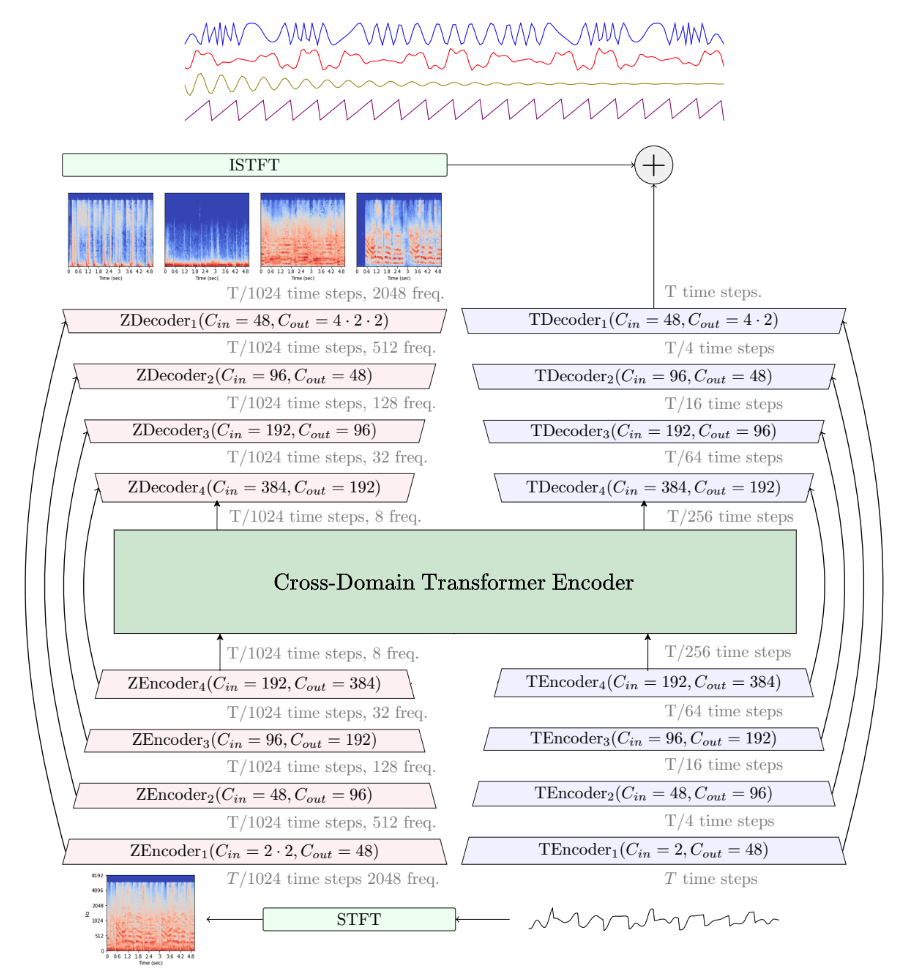

In [33]:
import os
import torch
import numpy as np
import soundfile as sf
import librosa

from demucs.pretrained import get_model
from demucs.apply import apply_model

def separate_demucs_inprocess(
    input_wav_path,
    output_wav_path="denoised_demucs.wav",
    model_name="htdemucs",
    stem="vocals",
    device="cpu"
):
    """
    Load audio with librosa (so we don't depend on ffmpeg/torchaudio),
    convert to stereo if needed (Demucs expects 2ch),
    run Demucs source separation in-process,
    and save the requested stem (e.g. 'vocals').

    Returns:
        y_clean (np.ndarray), sr (int), stems (list[str])
    """

    # 1. Load audio (mono float32)
    y_mono, sr = librosa.load(input_wav_path, sr=None, mono=True)

    # Safety normalize a bit
    if np.max(np.abs(y_mono)) > 0:
        y_mono = 0.99 * y_mono / np.max(np.abs(y_mono))

    # 2. Demucs expects stereo: [batch, channels=2, samples]
    # We'll fake stereo by duplicating the mono channel.
    y_stereo = np.stack([y_mono, y_mono], axis=0)  # shape [2, T]

    # Turn into torch tensor
    mix_tensor = torch.tensor(y_stereo, dtype=torch.float32, device=device).unsqueeze(0)
    # shape now [1, 2, T]

    # 3. Load Demucs model
    model = get_model(model_name)
    model.to(device)
    model.eval()

    with torch.no_grad():
        # apply_model expects [batch, channels, samples]
        # returns tensor [batch, stems, channels, samples]
        estimates = apply_model(
            model,
            mix_tensor,
            device=device
        )

    # Move to CPU numpy
    estimates = estimates.squeeze(0).cpu().numpy()  # [stems, channels, T]
    stems = model.sources                          # list of stem names in order

    if stem not in stems:
        raise ValueError(
            f"Requested stem '{stem}' not in model sources {stems}"
        )

    stem_idx = stems.index(stem)

    # Pick that stem -> shape [channels, T]
    chosen_stem = estimates[stem_idx]

    # Downmix back to mono (average channels)
    if chosen_stem.ndim == 2:
        y_clean = np.mean(chosen_stem, axis=0)
    else:
        y_clean = chosen_stem

    # Light renormalize output
    if np.max(np.abs(y_clean)) > 0:
        y_clean = 0.99 * y_clean / np.max(np.abs(y_clean))

    # 4. Save cleaned stem to disk
    sf.write(output_wav_path, y_clean, sr)

    return y_clean, sr, stems


In [34]:
y_clean, sr, stems = separate_demucs_inprocess(
    input_wav_path="denoised_whale_1.wav",
    output_wav_path="denoised_whale_1_cleaned.wav",
    model_name="htdemucs",
    stem="vocals",
    device="cpu"
)

print("Available stems in this model:", stems)
print("Cleaned file written to denoised_whale_1_cleaned.wav")


Available stems in this model: ['drums', 'bass', 'other', 'vocals']
Cleaned file written to denoised_whale_1_cleaned.wav


## Open-Unmix PyTorch 

is a deep neural network reference implementation for music source separation built on PyTorch 1.8+. The system separates mixed audio recordings into four distinct stems: vocals, drums, bass, and other instruments. It serves as both a research baseline and a production-ready tool for audio engineers, researchers, and artists.

The system is designed around the principle of simplicity over performance optimization, making it an ideal starting point for music separation research while still achieving state-of-the-art results comparable to SiSEC 2018 participants.

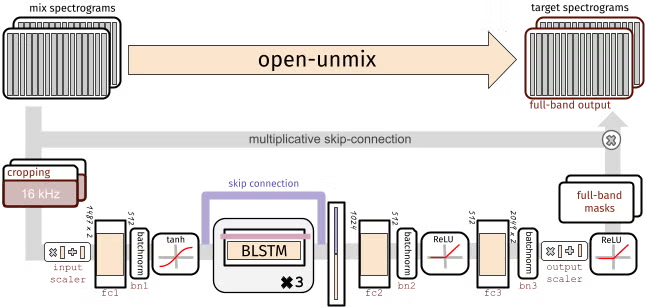

In [46]:
import torch
import librosa
import soundfile as sf
import numpy as np
import os

def _ensure_mono_from_estimate(arr):
    """
    Takes an array that could be shaped:
    - [C, T]
    - [N_targets, C, T]
    - [B, C, T]
    - [B, N_targets, C, T]
    and returns mono [T] as float32.
    """
    a = np.array(arr)

    # Case 1: [B, N_targets, C, T]
    if a.ndim == 4:
        # take batch 0, target 0
        a = a[0, 0]  # -> [C, T]

    # Case 2: [B, C, T]
    elif a.ndim == 3:
        # take batch 0
        a = a[0]     # -> [C, T]

    # Case 3: [N_targets, C, T]
    elif a.ndim == 3 and a.shape[0] > 2 and a.shape[1] <= 2:
        # (this branch will be covered by previous elif, but left here for clarity)
        a = a[0]     # -> [C, T]

    # Case 4: [C, T]
    elif a.ndim == 2:
        # already fine
        pass

    else:
        # unexpected, try flatten last
        a = np.squeeze(a)

    # Now we expect [C, T] or [T]
    if a.ndim == 2:
        # average channels -> mono
        a = a.mean(axis=0)

    # Now we expect [T]
    if a.ndim != 1:
        a = np.squeeze(a)

    # Cleanup dtype / NaNs / normalize
    a = a.astype(np.float32, copy=False)
    if np.isnan(a).any() or np.isinf(a).any():
        a = np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)

    max_abs = float(np.max(np.abs(a))) if a.size else 0.0
    if max_abs > 0:
        a = 0.99 * (a / max_abs)

    return a.astype(np.float32, copy=False)


def separate_openunmix(
    input_wav_path,
    output_wav_path="clean_openunmix.wav",
    keep_stem="vocals",
    device="cpu",
    model_name="umxhq"
):
    """
    Run Open-Unmix on the input_wav_path, extract `keep_stem`
    (e.g. 'vocals' used as "foreground whale"), save mono cleaned audio,
    and return (y_clean, sr, stems_available).

    This version:
    - handles multiple output shapes from different UMX builds
    - forces stereo input
    - resamples to 44.1kHz
    - guarantees sf.write gets a 1D float32 array
    """

    # -------------------------------------------------
    # 0. Make sure output dir exists
    # -------------------------------------------------
    out_dir = os.path.dirname(output_wav_path)
    if out_dir and not os.path.exists(out_dir):
        os.makedirs(out_dir, exist_ok=True)

    # -------------------------------------------------
    # 1. Load + prep audio
    # -------------------------------------------------
    y, sr = librosa.load(input_wav_path, sr=None, mono=True)

    target_sr = 44100
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    if y.size == 0 or np.max(np.abs(y)) == 0:
        raise ValueError("Audio appears empty or silent; nothing to separate.")

    # normalize a bit
    peak = np.max(np.abs(y))
    if peak > 0:
        y = 0.99 * y / peak

    # fake stereo for UMX: (2, T)
    y_stereo = np.stack([y, y], axis=0).astype(np.float32)
    mix_tensor = torch.tensor(y_stereo, dtype=torch.float32, device=device).unsqueeze(0)
    # shape [1, 2, T]

    # -------------------------------------------------
    # 2. Load model with >=2 targets so EM doesn't complain
    # -------------------------------------------------
    targets = ["vocals", "other"]
    umx = torch.hub.load(
        "sigsep/open-unmix-pytorch",
        "umx",
        targets=targets,
        device=device,
        pretrained=True
    )
    umx.eval()

    # -------------------------------------------------
    # 3. Forward pass
    # -------------------------------------------------
    with torch.no_grad():
        estimates = umx(mix_tensor)

    # -------------------------------------------------
    # 4. Interpret output
    # -------------------------------------------------
    if isinstance(estimates, dict):
        # dict mode {stem_name: tensor}
        available = list(estimates.keys())
        if keep_stem not in available:
            raise ValueError(
                f"Requested stem '{keep_stem}' not in {available}"
            )

        chosen = estimates[keep_stem].cpu().numpy()
        # chosen could be [B, C, T] or [B, N_targets, C, T] depending on impl
        y_clean = _ensure_mono_from_estimate(chosen)

    else:
        # tensor mode
        # Could be [B, C, T] or [B, N_targets, C, T]
        available = [keep_stem]
        chosen = estimates.cpu().numpy()
        y_clean = _ensure_mono_from_estimate(chosen)

    # -------------------------------------------------
    # 5. Final safety: types/shapes for saving
    # -------------------------------------------------
    sr = int(sr)
    if y_clean.ndim != 1:
        # flatten as last resort
        y_clean = np.ravel(y_clean).astype(np.float32)

    if y_clean.size == 0:
        raise ValueError("Open-Unmix produced empty output after squeezing.")

    # -------------------------------------------------
    # 6. Debug info
    # -------------------------------------------------
    print("DEBUG before write:")
    print(" - output:", output_wav_path)
    print(" - shape:", y_clean.shape)
    print(" - dtype:", y_clean.dtype)
    print(" - sr:", sr)
    print(" - max|y|:", float(np.max(np.abs(y_clean))))
    print(" - stems available:", available)

    # -------------------------------------------------
    # 7. Save cleaned mono stem
    # -------------------------------------------------
    sf.write(output_wav_path, y_clean, sr)

    print(f"✅ Open-Unmix cleaned audio saved to {output_wav_path}")

    return y_clean, sr, available


In [47]:
y_clean, sr, stems = separate_openunmix(
    input_wav_path="denoised_whale_1.wav",
    output_wav_path="denoised_whale_1_umx_clean.wav",
    keep_stem="vocals",
    device="cpu",
    model_name="umxhq"
)

print("stems available:", stems)
print("sample rate:", sr)
print("cleaned length samples:", len(y_clean))


Using cache found in C:\Users\edupa/.cache\torch\hub\sigsep_open-unmix-pytorch_master


DEBUG before write:
 - output: denoised_whale_1_umx_clean.wav
 - shape: (841728,)
 - dtype: float32
 - sr: 44100
 - max|y|: 0.9900000095367432
 - stems available: ['vocals']
✅ Open-Unmix cleaned audio saved to denoised_whale_1_umx_clean.wav
stems available: ['vocals']
sample rate: 44100
cleaned length samples: 841728


In [48]:
feats = extract_band_features(y_clean, sr)
print(feats)


{'low_freq_hz': 172.265625, 'high_freq_hz': 4554.2724609375, 'bandwidth_hz': 4382.0068359375, 'centroid_mean_hz': 2525.2575598701196, 'rms_mean': 0.04969177395105362, 'duration_sec': 19.086802721088436}


## Spectogram Analysis

We will analyse the results of the 3 approaches intuition to choose which is best for isolating whale sound.

1. Original + STFT
2. STFT + demucs (Hybrid transformer)
3. STFT + openmix (three-layer bidirectional deep LSTM)

<>:9: SyntaxWarning: invalid escape sequence '\R'
<>:9: SyntaxWarning: invalid escape sequence '\R'
C:\Users\edupa\AppData\Local\Temp\ipykernel_17324\591998113.py:9: SyntaxWarning: invalid escape sequence '\R'
  original_path   = "..\ReferenceAudio\BlueWhaleCrying.wav"


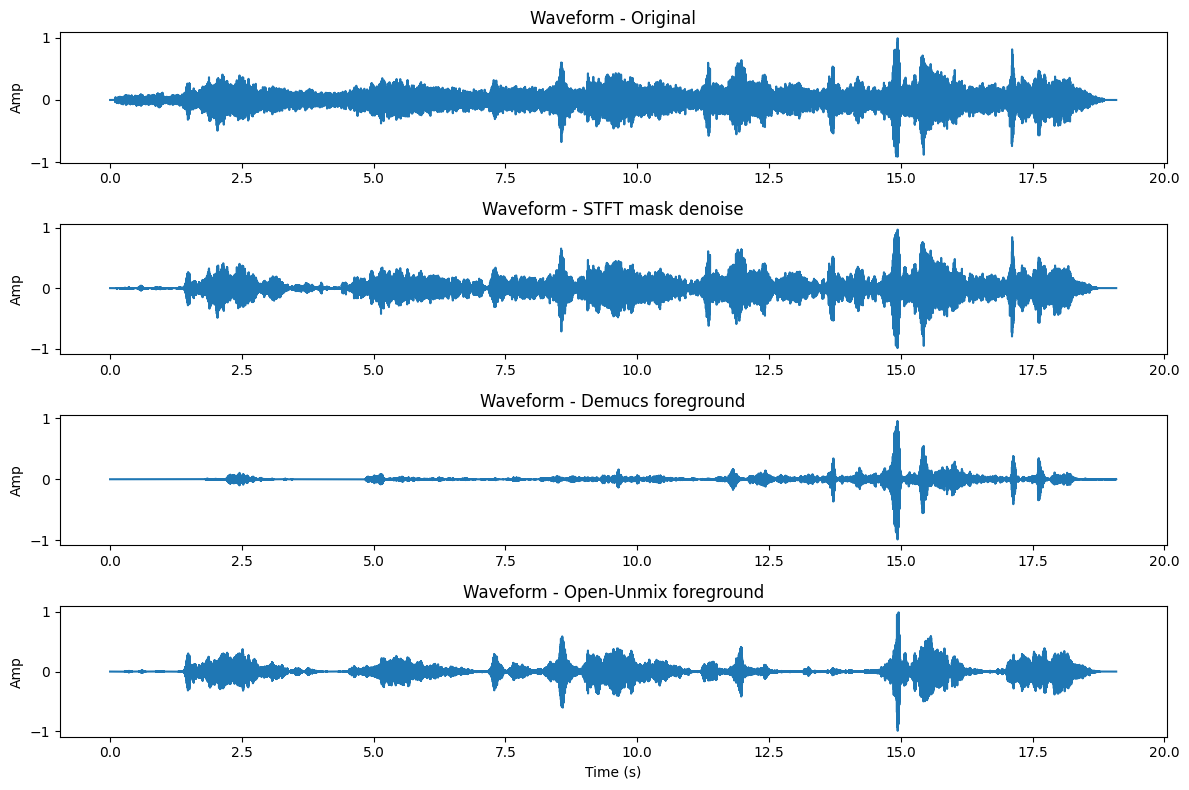

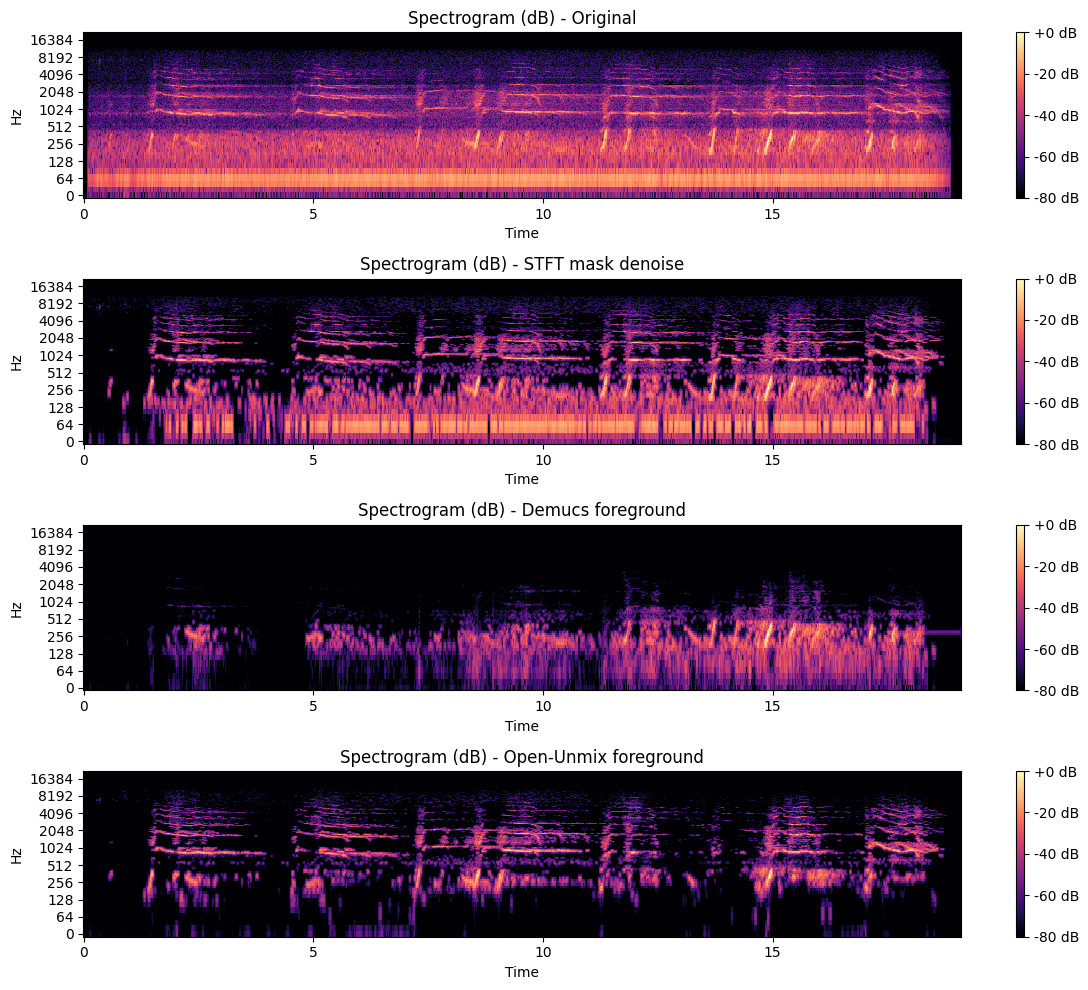

       label  duration_sec  band_low_Hz  band_high_Hz  bandwidth_Hz  \
0   original     19.086803    32.299805   2637.817383   2605.517578   
1  stft_mask     19.086803    21.533203   2659.350586   2637.817383   
2     demucs     19.086803    10.766602    710.595703    699.829102   
3  openunmix     19.086803   172.265625   4554.272461   4382.006836   

   centroid_mean_Hz  rms_mean  noise_floor_dB  
0       1486.532752  0.092163      -42.906578  
1       1997.668811  0.084483      -58.034195  
2       1589.772212  0.021850      -79.825111  
3       2618.849467  0.049691      -67.046921  


In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# 1. CONFIG: set your files here
# -------------------------------------------------
original_path   = "..\ReferenceAudio\BlueWhaleCrying.wav"
stft_path       = "denoised_whale_1.wav"            # from your spectral mask method
demucs_path     = "denoised_whale_1_cleaned.wav"          # from separate_demucs_inprocess
openunmix_path  = "denoised_whale_1_umx_clean.wav"       # from separate_openunmix

common_sr = 44100  # we'll resample all to same rate for fair plotting


# -------------------------------------------------
# 2. Load helper
# -------------------------------------------------
def load_audio(path, target_sr):
    y, sr = librosa.load(path, sr=None, mono=True)
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    # light normalize just for visualization comparability
    if np.max(np.abs(y)) > 0:
        y = 0.99 * y / np.max(np.abs(y))
    return y, sr


# -------------------------------------------------
# 3. Load all versions
# -------------------------------------------------
y_orig, sr_orig = load_audio(original_path, common_sr)
y_stft, sr_stft = load_audio(stft_path,     common_sr)
y_dem , sr_dem  = load_audio(demucs_path,   common_sr)
y_umx , sr_umx  = load_audio(openunmix_path,common_sr)

# sanity check: all sr should now match common_sr
sr = common_sr


# -------------------------------------------------
# 4. Compute spectrograms (dB) for visual comparison
# -------------------------------------------------
def make_spectrogram_db(y, sr, n_fft=2048, hop_length=512):
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    S_db = librosa.amplitude_to_db(S, ref=np.max)
    return S_db

Sdb_orig = make_spectrogram_db(y_orig, sr)
Sdb_stft = make_spectrogram_db(y_stft, sr)
Sdb_dem  = make_spectrogram_db(y_dem,  sr)
Sdb_umx  = make_spectrogram_db(y_umx,  sr)

t_orig = np.linspace(0, len(y_orig)/sr, num=len(y_orig))
t_stft = np.linspace(0, len(y_stft)/sr, num=len(y_stft))
t_dem  = np.linspace(0, len(y_dem)/sr,  num=len(y_dem))
t_umx  = np.linspace(0, len(y_umx)/sr,  num=len(y_umx))


# -------------------------------------------------
# 5. Plot waveforms stacked
# -------------------------------------------------
plt.figure(figsize=(12, 8))

plt.subplot(4,1,1)
plt.plot(t_orig, y_orig)
plt.title("Waveform - Original")
plt.ylabel("Amp")

plt.subplot(4,1,2)
plt.plot(t_stft, y_stft)
plt.title("Waveform - STFT mask denoise")
plt.ylabel("Amp")

plt.subplot(4,1,3)
plt.plot(t_dem, y_dem)
plt.title("Waveform - Demucs foreground")
plt.ylabel("Amp")

plt.subplot(4,1,4)
plt.plot(t_umx, y_umx)
plt.title("Waveform - Open-Unmix foreground")
plt.ylabel("Amp")
plt.xlabel("Time (s)")

plt.tight_layout()
plt.show()


# -------------------------------------------------
# 6. Plot spectrograms stacked (log-freq)
# -------------------------------------------------
plt.figure(figsize=(12, 10))

plt.subplot(4,1,1)
librosa.display.specshow(
    Sdb_orig, sr=sr, hop_length=512,
    x_axis="time", y_axis="log"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB) - Original")

plt.subplot(4,1,2)
librosa.display.specshow(
    Sdb_stft, sr=sr, hop_length=512,
    x_axis="time", y_axis="log"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB) - STFT mask denoise")

plt.subplot(4,1,3)
librosa.display.specshow(
    Sdb_dem, sr=sr, hop_length=512,
    x_axis="time", y_axis="log"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB) - Demucs foreground")

plt.subplot(4,1,4)
librosa.display.specshow(
    Sdb_umx, sr=sr, hop_length=512,
    x_axis="time", y_axis="log"
)
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB) - Open-Unmix foreground")

plt.tight_layout()
plt.show()


# -------------------------------------------------
# 7. Quantitative metrics for decision-making
# -------------------------------------------------
def noise_floor_estimate(y, sr, n_fft=2048, hop_length=512):
    """
    crude 'background level':
    take quietest 20% frames by RMS and average their energy in dB.
    Lower = better noise suppression (usually).
    """
    rms_frames = librosa.feature.rms(
        y=y, frame_length=2048, hop_length=hop_length
    )[0]  # shape [frames]

    if rms_frames.size == 0:
        return 0.0

    # sort rms, take bottom 20%
    k = max(1, int(0.2 * len(rms_frames)))
    quiet_frames = np.sort(rms_frames)[:k]

    # convert to dB relative to full-scale
    quiet_db = 20 * np.log10(quiet_frames + 1e-12)
    return float(np.mean(quiet_db))


def summarize_clip(y, sr, label):
    feats = extract_band_features(y, sr)
    bg_db = noise_floor_estimate(y, sr)

    return {
        "label": label,
        "duration_sec": feats["duration_sec"],
        "band_low_Hz": feats["low_freq_hz"],
        "band_high_Hz": feats["high_freq_hz"],
        "bandwidth_Hz": feats["bandwidth_hz"],
        "centroid_mean_Hz": feats["centroid_mean_hz"],
        "rms_mean": feats["rms_mean"],
        "noise_floor_dB": bg_db
    }

stats_list = [
    summarize_clip(y_orig, sr, "original"),
    summarize_clip(y_stft, sr, "stft_mask"),
    summarize_clip(y_dem,  sr, "demucs"),
    summarize_clip(y_umx,  sr, "openunmix"),
]





In [ ]:
import pandas as pd
stats_df = pd.DataFrame(stats_list)
stats_df

,label,duration_sec,band_low_Hz,band_high_Hz,bandwidth_Hz,centroid_mean_Hz,rms_mean,noise_floor_dB
0,original,19.086803,32.299805,2637.817383,2605.517578,1486.532752,0.092163,-42.906578
1,stft_mask,19.086803,21.533203,2659.350586,2637.817383,1997.668811,0.084483,-58.034195
2,demucs,19.086803,10.766602,710.595703,699.829102,1589.772212,0.021850,-79.825111
3,openunmix,19.086803,172.265625,4554.272461,4382.006836,2618.849467,0.049691,-67.046921


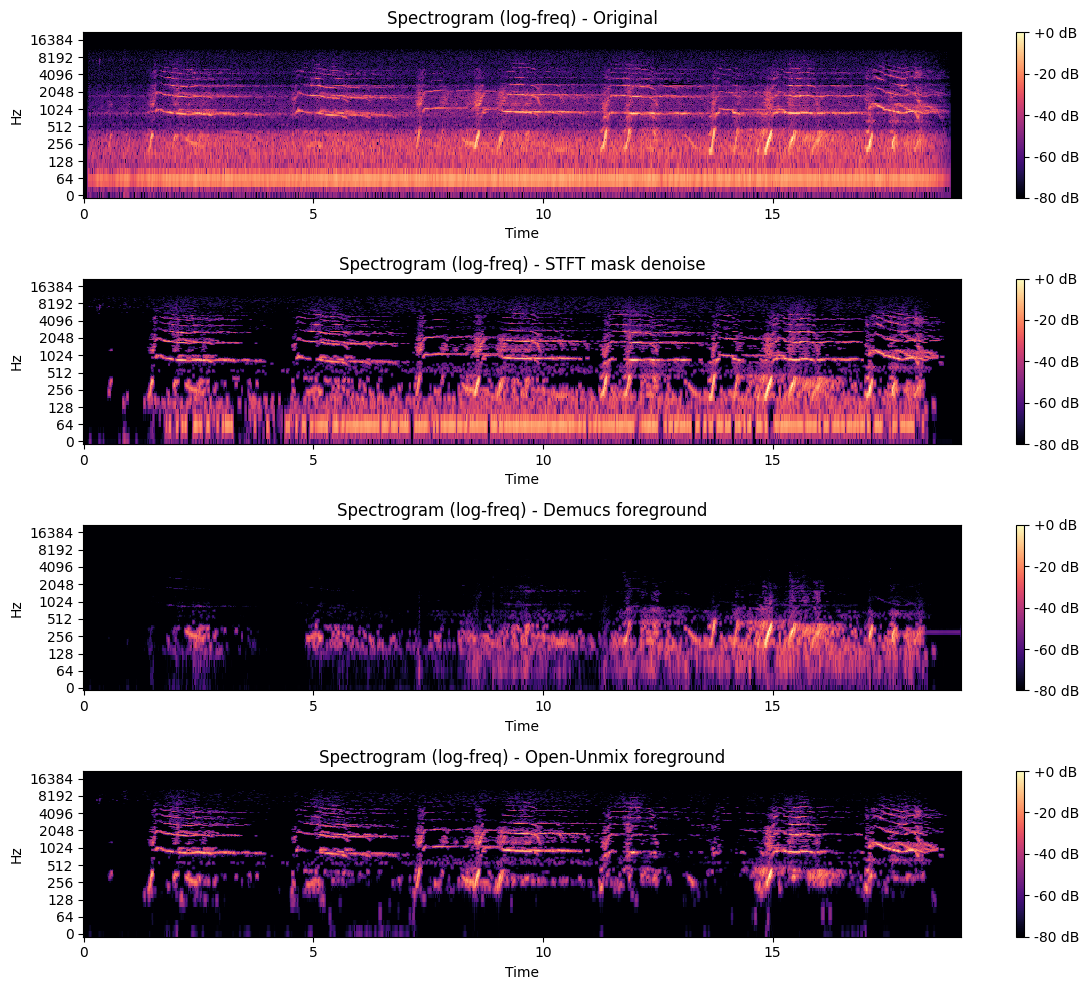

In [51]:
plt.figure(figsize=(12, 10))

titles = [
    "Original",
    "STFT mask denoise",
    "Demucs foreground",
    "Open-Unmix foreground"
]
spectrograms = [Sdb_orig, Sdb_stft, Sdb_dem, Sdb_umx]

for i, (title, S_db) in enumerate(zip(titles, spectrograms), 1):
    plt.subplot(4, 1, i)
    librosa.display.specshow(
        S_db, sr=sr, hop_length=512,
        x_axis="time", y_axis="log", cmap="magma"
    )
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Spectrogram (log-freq) - {title}")

plt.tight_layout()
plt.show()
